In [1]:
# Data preprocessing + cleansing + Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
pd.options.mode.chained_assignment = None  

In [3]:
#import dataframe
df = pd.read_csv("Cleaned_OSEFX_Market_Macro_Data.csv", dtype ={"comp_tpci": str})
df["Date"] = pd.to_datetime(df["Date"])    #convert to date format
df.head()

,Date,Instrument,ClosePrice,OpenPrice,Volume,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,...,BrentOil,USDNOK,EURNOK,US10Y,USCPI,USGDPGrowth,NorwegianCPI,NIBOR3M,NorgesBank10Y,OSEBXReturns
0,1995-01-31,DNB.OL,17.3773,17.2824,98464.0,17.1874,17.3773,0.0363,3.5518,1.0787,...,16.8,6.68,11.7673,0.076,150.5,0.014,66.6,0.0566,0.085,-0.0201
1,1995-01-31,ATEA.OL,47.0691,47.0691,131.0,94.1381,73.2932,0.0363,3.5518,1.0787,...,16.8,6.68,11.7673,0.076,150.5,0.014,66.6,0.0566,0.085,-0.0201
2,1995-01-31,TOM.OL,2.1000,1.9875,1427999.0,7.4375,7.5000,0.0363,0.0954,1.0787,...,16.8,6.68,11.7673,0.076,150.5,0.014,66.6,0.0566,0.085,-0.0201
3,1995-01-31,SB1NO.OL,11.1071,11.1071,30503.0,11.0153,11.0612,0.0363,3.5518,1.0787,...,16.8,6.68,11.7673,0.076,150.5,0.014,66.6,0.0566,0.085,-0.0201
4,1995-01-31,NHY.OL,14.2156,13.9733,1944233.0,20.6772,20.7580,0.0363,17.3193,1.0787,...,16.8,6.68,11.7673,0.076,150.5,0.014,66.6,0.0566,0.085,-0.0201


In [4]:
print(df.columns)

Index(['Date', 'Instrument', 'ClosePrice', 'OpenPrice', 'Volume', 'BidPrice',
       'AskPrice', 'DividendYield', 'BookValuePerShare', 'Beta', 'MarketCap',
       'CommonSharesOutstanding', 'MonthlyReturn', 'EconomicSector',
       'EarningsPerShare', 'Momentum_3M', 'Momentum_6M', 'Momentum_12M',
       'Volatility_3M', 'Volatility_6M', 'Volatility_12M', 'BidAskSpread',
       'TurnoverRatio', 'BM', 'BrentOil', 'USDNOK', 'EURNOK', 'US10Y', 'USCPI',
       'USGDPGrowth', 'NorwegianCPI', 'NIBOR3M', 'NorgesBank10Y',
       'OSEBXReturns'],
      dtype='object')


In [5]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# Sort data
df = df.sort_values(by=["Instrument", "Date"]).reset_index(drop=True)

# Monthly return and adjusted return (winsorized)
df["MonthlyReturn"] = df.groupby("Instrument")["ClosePrice"].pct_change()
df["MonthlyReturn"] = winsorize(df["MonthlyReturn"].values, limits=[0.01, 0.01])
df["AdjustedReturn"] = df["MonthlyReturn"] - (df["NorgesBank10Y"] / 12)

# Create lead target: next month's adjusted return
df["AdjustedReturn_lead1m"] = df.groupby("Instrument")["AdjustedReturn"].shift(-1)

# Create term spread
df["TermSpread"] = df["NorgesBank10Y"] - df["NIBOR3M"]

# Recalculate MarketCap
df["MarketCap"] = df["ClosePrice"] * df["CommonSharesOutstanding"]

# Fix column names for modeling
df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

# Log-transform relevant variables
for var in ["MarketCap", "BM", "ClosePrice", "Volume", "CommonSharesOutstanding"]:
    df[var] = df[var].where(df[var] > 0, np.nan)  # filter out non-positive values
    df[f"log_{var}"] = np.log(df[var])

# Done!
df.head(100)


,Date,Instrument,ClosePrice,OpenPrice,Volume,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,...,NorgesBank10Y,OSEBXReturns,AdjustedReturn,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_Volume,log_CommonSharesOutstanding
0,2017-12-31,20202.OL,36.2768,36.2768,NaN,36.2768,33.6224,0.0073,11.5122,0.5920,...,0.0195,0.0221,0.790544,0.120143,0.0114,21.803865,-1.369241,3.591178,NaN,18.212686
1,2018-01-31,20202.OL,40.7008,40.7008,NaN,36.2768,40.7008,0.0071,11.6556,0.5609,...,0.0217,-0.0042,0.120143,-0.154124,0.0132,21.918934,-1.322381,3.706248,NaN,18.212686
2,2018-02-28,20202.OL,34.5072,34.5072,NaN,35.3920,38.9312,0.0110,11.8594,0.5734,...,0.0234,0.0108,-0.154124,0.075065,0.0133,19.173293,-1.244101,3.541168,NaN,15.632125
3,2018-03-31,20202.OL,37.1616,37.1616,NaN,37.1616,38.9312,0.0106,11.8594,0.5361,...,0.0223,-0.0176,0.075065,0.117164,0.0106,19.247401,-1.229291,3.615276,NaN,15.632125
4,2018-04-30,20202.OL,41.5856,41.5856,NaN,41.5856,61.9361,0.0075,11.8594,0.5802,...,0.0226,0.0678,0.117164,0.040772,0.0115,19.359879,-1.265848,3.727754,NaN,15.632125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1995-11-30,ABGA.OL,1.7369,1.8124,83000.0,1.7369,1.8124,0.0363,2.6320,1.0787,...,0.0696,0.0217,-0.251708,0.037802,0.0169,19.544462,-3.634391,0.552102,11.326596,18.992360
96,1995-12-31,ABGA.OL,1.8124,1.6992,NaN,1.7747,1.8124,0.0363,2.6320,1.0787,...,0.0680,0.0173,0.037802,-0.089123,0.0153,19.587012,-3.582719,0.594652,NaN,18.992360
97,1996-01-31,ABGA.OL,1.6614,1.6614,97000.0,1.6388,1.6614,0.0363,2.6320,1.0787,...,0.0697,-0.0787,-0.089123,0.334842,0.0144,19.500020,-3.665163,0.507661,11.482466,18.992360
98,1996-02-29,ABGA.OL,2.2278,2.1900,558000.0,2.1900,2.2278,0.0363,11.7629,1.0787,...,0.0729,0.0119,0.334842,-0.050038,0.0211,17.993005,-2.430418,0.801015,13.232114,17.191990


In [6]:
df = df.dropna( how='any',subset=["AdjustedReturn_lead1m"])

In [7]:
print(df.columns)

Index(['Date', 'Instrument', 'ClosePrice', 'OpenPrice', 'Volume', 'BidPrice',
       'AskPrice', 'DividendYield', 'BookValuePerShare', 'Beta', 'MarketCap',
       'CommonSharesOutstanding', 'MonthlyReturn', 'EconomicSector',
       'EarningsPerShare', 'Momentum_3M', 'Momentum_6M', 'Momentum_12M',
       'Volatility_3M', 'Volatility_6M', 'Volatility_12M', 'BidAskSpread',
       'TurnoverRatio', 'BM', 'BrentOil', 'USDNOK', 'EURNOK', 'US10Y', 'USCPI',
       'USGDPGrowth', 'NorwegianCPI', 'NIBOR3M', 'NorgesBank10Y',
       'OSEBXReturns', 'AdjustedReturn', 'AdjustedReturn_lead1m', 'TermSpread',
       'log_MarketCap', 'log_BM', 'log_ClosePrice', 'log_Volume',
       'log_CommonSharesOutstanding'],
      dtype='object')


In [8]:
print(len(df))

34288


In [9]:
pd.set_option('display.max_rows',None)
df.isna().sum().sort_values(ascending = False)

log_Volume                     13558
Volume                         13558
BM                               671
log_BM                           671
log_CommonSharesOutstanding        8
MarketCap                          8
CommonSharesOutstanding            8
log_MarketCap                      8
TermSpread                         0
AdjustedReturn_lead1m              0
AdjustedReturn                     0
log_ClosePrice                     0
OSEBXReturns                       0
NorgesBank10Y                      0
NIBOR3M                            0
NorwegianCPI                       0
USGDPGrowth                        0
USCPI                              0
US10Y                              0
EURNOK                             0
USDNOK                             0
BrentOil                           0
Date                               0
TurnoverRatio                      0
MonthlyReturn                      0
ClosePrice                         0
OpenPrice                          0
B

In [10]:
limitPer = len(df) * .75
df = df.dropna(thresh=limitPer, axis=1)

In [11]:
pd.set_option('display.max_rows',None)
df.isna().sum().sort_values(ascending = False)

BM                             671
log_BM                         671
log_MarketCap                    8
MarketCap                        8
log_CommonSharesOutstanding      8
CommonSharesOutstanding          8
TermSpread                       0
AdjustedReturn_lead1m            0
AdjustedReturn                   0
OSEBXReturns                     0
log_ClosePrice                   0
TurnoverRatio                    0
NorgesBank10Y                    0
NIBOR3M                          0
NorwegianCPI                     0
USGDPGrowth                      0
USCPI                            0
US10Y                            0
EURNOK                           0
USDNOK                           0
BrentOil                         0
Date                             0
Instrument                       0
Volatility_12M                   0
ClosePrice                       0
OpenPrice                        0
BidPrice                         0
AskPrice                         0
DividendYield       

In [12]:
# Identify only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Fill missing values in numeric columns with group-wise median
df[numeric_cols] = df.groupby("Date")[numeric_cols].transform(lambda x: x.fillna(x.median()))


In [13]:
pd.set_option('display.max_rows',None)
df.isna().sum().sort_values(ascending = False)

Date                           0
Instrument                     0
BM                             0
BrentOil                       0
USDNOK                         0
EURNOK                         0
US10Y                          0
USCPI                          0
USGDPGrowth                    0
NorwegianCPI                   0
NIBOR3M                        0
NorgesBank10Y                  0
OSEBXReturns                   0
AdjustedReturn                 0
AdjustedReturn_lead1m          0
TermSpread                     0
log_MarketCap                  0
log_BM                         0
log_ClosePrice                 0
TurnoverRatio                  0
BidAskSpread                   0
Volatility_12M                 0
MarketCap                      0
ClosePrice                     0
OpenPrice                      0
BidPrice                       0
AskPrice                       0
DividendYield                  0
BookValuePerShare              0
Beta                           0
CommonShar

In [14]:
print(len(df))

34288


# Explore the data before treating

In [15]:
df = df.sort_values(by=['Instrument', "Date"])
df.head(50)

,Date,Instrument,ClosePrice,OpenPrice,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,MarketCap,...,NIBOR3M,NorgesBank10Y,OSEBXReturns,AdjustedReturn,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_CommonSharesOutstanding
0,2017-12-31,20202.OL,36.2768,36.2768,36.2768,33.6224,0.0073,11.5122,0.5920,2.946444e+09,...,0.0081,0.0195,0.0221,0.790544,0.120143,0.0114,21.803865,-1.369241,3.591178,18.212686
1,2018-01-31,20202.OL,40.7008,40.7008,36.2768,40.7008,0.0071,11.6556,0.5609,3.305767e+09,...,0.0085,0.0217,-0.0042,0.120143,-0.154124,0.0132,21.918934,-1.322381,3.706248,18.212686
2,2018-02-28,20202.OL,34.5072,34.5072,35.3920,38.9312,0.0110,11.8594,0.5734,2.122538e+08,...,0.0101,0.0234,0.0108,-0.154124,0.075065,0.0133,19.173293,-1.244101,3.541168,15.632125
3,2018-03-31,20202.OL,37.1616,37.1616,37.1616,38.9312,0.0106,11.8594,0.5361,2.285810e+08,...,0.0117,0.0223,-0.0176,0.075065,0.117164,0.0106,19.247401,-1.229291,3.615276,15.632125
4,2018-04-30,20202.OL,41.5856,41.5856,41.5856,61.9361,0.0075,11.8594,0.5802,2.557930e+08,...,0.0111,0.0226,0.0678,0.117164,0.040772,0.0115,19.359879,-1.265848,3.727754,15.632125
5,2018-05-31,20202.OL,43.3553,43.3553,47.7793,66.3601,0.0000,12.0740,0.5467,2.666785e+08,...,0.0100,0.0214,0.0181,0.040772,0.100249,0.0114,19.401554,-1.276543,3.769429,15.632125
6,2018-06-30,20202.OL,47.7793,47.7793,48.6641,68.1297,0.0000,12.0740,0.5857,2.938905e+08,...,0.0098,0.0215,0.0041,0.100249,0.109228,0.0117,19.498718,-1.318262,3.866592,15.632125
7,2018-07-31,20202.OL,53.0881,53.0881,57.5121,70.7841,0.0000,12.0740,0.5776,3.265449e+08,...,0.0103,0.0226,0.0196,0.109228,0.248208,0.0123,19.604078,-1.358290,3.971953,15.632125
8,2018-08-31,20202.OL,66.3601,66.3601,66.3601,79.6321,0.0058,12.0740,0.5566,4.081810e+08,...,0.0103,0.0215,0.0115,0.248208,-0.001925,0.0112,19.827221,-1.400799,4.195096,15.632125
9,2018-09-30,20202.OL,66.3601,66.3601,49.1065,88.4801,0.0083,12.0740,0.5333,4.081810e+08,...,0.0110,0.0231,0.0348,-0.001925,-0.001917,0.0121,19.827221,-1.418404,4.195096,15.632125


In [16]:
#the new observation period 
print(df['Date'].nunique())

359


In [17]:
#There are 1855 unique german stocks
print(df['Instrument'].nunique())

188


In [18]:
#Inspect variable types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 34288 entries, 0 to 34474
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         34288 non-null  datetime64[ns]
 1   Instrument                   34288 non-null  object        
 2   ClosePrice                   34288 non-null  float64       
 3   OpenPrice                    34288 non-null  float64       
 4   BidPrice                     34288 non-null  float64       
 5   AskPrice                     34288 non-null  float64       
 6   DividendYield                34288 non-null  float64       
 7   BookValuePerShare            34288 non-null  float64       
 8   Beta                         34288 non-null  float64       
 9   MarketCap                    34288 non-null  float64       
 10  CommonSharesOutstanding      34288 non-null  float64       
 11  MonthlyReturn                34288 non-null  f

In [19]:
# Select all numeric columns except Date/Instrument
variables = df.select_dtypes(include=[np.number]).columns.difference(['Date']).tolist()

# Winsorize numeric variables at 1st and 99th percentiles
for col in variables:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)


In [20]:
#Save dataset:
df.to_csv("Cleaned_OSEFX_Market_Macro_Data_new.csv", index = False)

In [21]:
#import dataframe
df = pd.read_csv("Cleaned_OSEFX_Market_Macro_Data_new.csv", dtype ={"comp_tpci": str})
df["Date"] = pd.to_datetime(df["Date"])    #convert to date format
df.head()

,Date,Instrument,ClosePrice,OpenPrice,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,MarketCap,...,NIBOR3M,NorgesBank10Y,OSEBXReturns,AdjustedReturn,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_CommonSharesOutstanding
0,2017-12-31,20202.OL,36.2768,36.2768,36.2768,33.6224,0.0073,11.5122,0.5920,2.946444e+09,...,0.0081,0.0195,0.0221,0.785085,0.120143,0.0114,21.803865,-1.369241,3.591178,18.212686
1,2018-01-31,20202.OL,40.7008,40.7008,36.2768,40.7008,0.0071,11.6556,0.5609,3.305767e+09,...,0.0085,0.0217,-0.0042,0.120143,-0.154124,0.0132,21.918934,-1.322381,3.706248,18.212686
2,2018-02-28,20202.OL,34.5072,34.5072,35.3920,38.9312,0.0110,11.8594,0.5734,2.122538e+08,...,0.0101,0.0234,0.0108,-0.154124,0.075065,0.0133,19.173293,-1.244101,3.541168,15.632125
3,2018-03-31,20202.OL,37.1616,37.1616,37.1616,38.9312,0.0106,11.8594,0.5361,2.285810e+08,...,0.0117,0.0223,-0.0176,0.075065,0.117164,0.0106,19.247401,-1.229291,3.615276,15.632125
4,2018-04-30,20202.OL,41.5856,41.5856,41.5856,61.9361,0.0075,11.8594,0.5802,2.557930e+08,...,0.0111,0.0226,0.0678,0.117164,0.040772,0.0115,19.359879,-1.265848,3.727754,15.632125


# Exploratory Data Analysis

In [22]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns 
sns.set()
%matplotlib inline
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
import pandas as pd
import numpy as np

# Read the CSV, parse dates
df = pd.read_csv("Cleaned_OSEFX_Market_Macro_Data_new.csv", parse_dates=["Date"])

# Sort by date and instrument (your actual columns)
df = df.sort_values(by=["Date", "Instrument"]).reset_index(drop=True)

# Convert numeric columns only to float32
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].astype("float32")

# Optional: Check the result
print(df.dtypes)
df.head()


Date                           datetime64[ns]
Instrument                             object
ClosePrice                            float32
OpenPrice                             float32
BidPrice                              float32
AskPrice                              float32
DividendYield                         float32
BookValuePerShare                     float32
Beta                                  float32
MarketCap                             float32
CommonSharesOutstanding               float32
MonthlyReturn                         float32
EconomicSector                         object
EarningsPerShare                      float32
Momentum_3M                           float32
Momentum_6M                           float32
Momentum_12M                          float32
Volatility_3M                         float32
Volatility_6M                         float32
Volatility_12M                        float32
BidAskSpread                          float32
TurnoverRatio                     

,Date,Instrument,ClosePrice,OpenPrice,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,MarketCap,...,NIBOR3M,NorgesBank10Y,OSEBXReturns,AdjustedReturn,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_CommonSharesOutstanding
0,1995-01-31,ABGA.OL,2.907500,2.945200,2.8697,2.907500,0.0363,3.5518,1.0787,4.846770e+08,...,0.0566,0.0736,-0.0201,0.785085,0.058002,0.0284,19.998993,-2.818423,1.067294,18.9317
1,1995-01-31,AFK.OL,11.897400,11.897400,14.7301,15.863200,0.0363,3.5518,1.0787,1.983283e+09,...,0.0566,0.0736,-0.0201,0.785085,0.016870,0.0284,21.408020,-2.818423,2.476320,18.9317
2,1995-01-31,ATEA.OL,47.069099,47.069099,94.1381,73.293198,0.0363,3.5518,1.0787,7.846366e+09,...,0.0566,0.0736,-0.0201,0.785085,-0.078362,0.0284,22.783316,-2.818423,3.851617,18.9317
3,1995-01-31,BELCO.OL,16.878401,17.245300,2.9354,5.136900,0.0363,3.5518,1.0787,2.813610e+09,...,0.0566,0.0736,-0.0201,0.785085,0.058286,0.0284,21.757734,-2.818423,2.826035,18.9317
4,1995-01-31,BONHR.OL,26.500000,26.250000,46.2500,47.250000,0.0363,3.5518,1.0787,4.417520e+09,...,0.0566,0.0736,-0.0201,0.785085,-0.072971,0.0284,22.208845,-2.818423,3.277145,18.9317


In [24]:
# The observation period contains 204 months in the period from 01.2003 to 12.2019'
# The last year is not uesed since we dont have the lead excess return  "ret_exc_lead1m" for January 2021 and we
# use 1 year for testing
df_2 = df[~(df['Date'] > '2024-12-31')]
print("Number of months: ", df_2["Date"].nunique())
print("Start: ", df_2["Date"].min())
print("End: ", df_2["Date"].max())

Number of months:  359
Start:  1995-01-31 00:00:00
End:  2024-11-30 00:00:00


In [25]:
#There are 1855 unique german stocks
print("Number of unique stcocks: ", df_2["Instrument"].nunique())

Number of unique stcocks:  188


In [26]:
#Inspect variable types
df_2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34288 entries, 0 to 34287
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         34288 non-null  datetime64[ns]
 1   Instrument                   34288 non-null  object        
 2   ClosePrice                   34288 non-null  float32       
 3   OpenPrice                    34288 non-null  float32       
 4   BidPrice                     34288 non-null  float32       
 5   AskPrice                     34288 non-null  float32       
 6   DividendYield                34288 non-null  float32       
 7   BookValuePerShare            34288 non-null  float32       
 8   Beta                         34288 non-null  float32       
 9   MarketCap                    34288 non-null  float32       
 10  CommonSharesOutstanding      34288 non-null  float32       
 11  MonthlyReturn                34288 non-nu

Minimum number of stocks per month:  27
Maximum number of stocks per month:  188
Mean number of stocks per month:  95.50974930362116


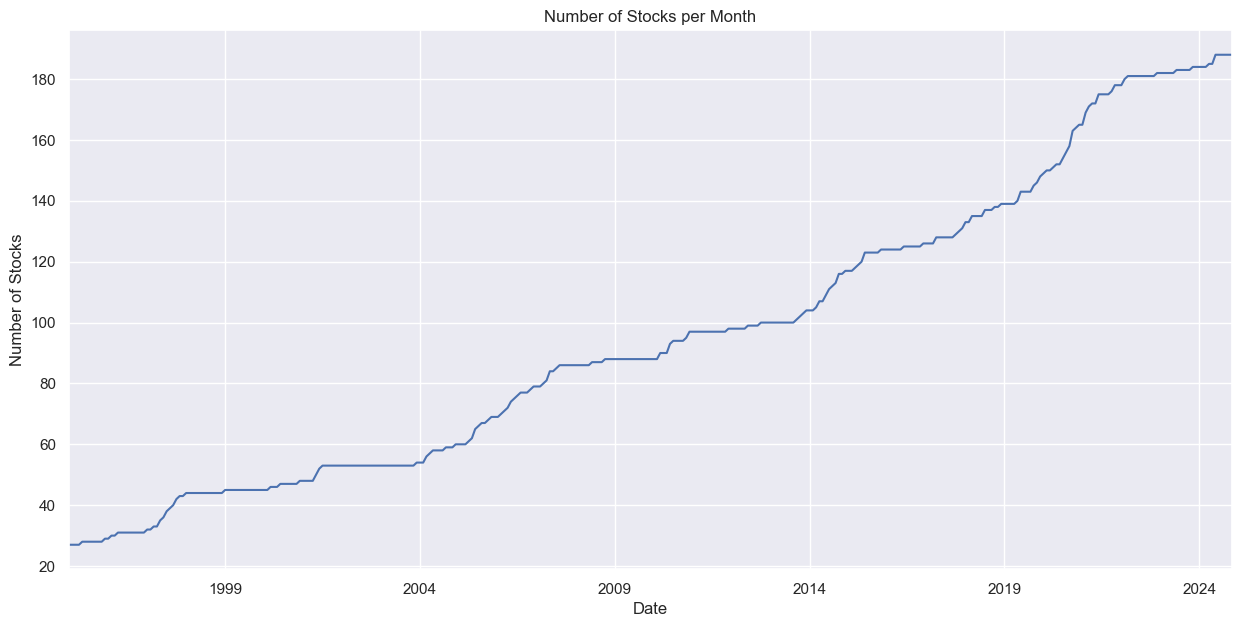

In [27]:
# Count number of stocks per month
from collections import Counter
import matplotlib.pyplot as plt

Number_stocks_per_month = Counter(df_2['Date'])  # use 'Date' instead of 'eom'
Number_stocks_per_month = pd.DataFrame(Number_stocks_per_month.items(), columns=['Date', 'Number_of_Stocks'])

# Convert 'Date' to datetime just in case
Number_stocks_per_month['Date'] = pd.to_datetime(Number_stocks_per_month['Date'])

# Print summary stats
print("Minimum number of stocks per month: ", Number_stocks_per_month["Number_of_Stocks"].min())
print("Maximum number of stocks per month: ", Number_stocks_per_month["Number_of_Stocks"].max())
print("Mean number of stocks per month: ", Number_stocks_per_month["Number_of_Stocks"].mean())

# Plot
Number_stocks_per_month = Number_stocks_per_month.sort_values("Date")
Number_stocks_per_month.plot(x='Date', y='Number_of_Stocks', grid=True, figsize=(15, 7), legend=False)
plt.ylabel("Number of Stocks")
plt.title("Number of Stocks per Month")
plt.show()


In [28]:
# We are interested in descriptive stats for stock-level features + target
features = df.columns[~df.columns.isin(['Instrument', 'ClosePrice', 'Date', 'MonthlyReturn', 'AdjustedReturn', "EconomicSector"])].tolist()

In [29]:
descriptive_statistics = df_2[features].describe()
descriptive_statistics

,OpenPrice,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,MarketCap,CommonSharesOutstanding,EarningsPerShare,Momentum_3M,...,NorwegianCPI,NIBOR3M,NorgesBank10Y,OSEBXReturns,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_CommonSharesOutstanding
count,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,3.428800e+04,3.428800e+04,34288.000000,34288.000000,...,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000,34288.000000
mean,1957.769531,2322.053467,2383.001221,0.028752,737.742371,0.984980,1.567567e+10,1.890872e+08,57.652008,0.024553,...,101.628891,0.027725,0.035049,0.009059,0.004355,0.007360,21.461828,-1.315024,3.745690,17.709011
std,13937.914062,16889.869141,17341.867188,0.036784,5089.263672,0.562722,4.815759e+10,3.533357e+08,465.134949,0.251959,...,17.903173,0.019593,0.016643,0.048757,0.138318,0.010002,2.080818,1.331758,2.060952,2.243528
min,0.800800,0.762000,0.813219,0.000000,-3.932400,-0.214843,8.283862e+06,3.484559e+03,-262.909393,-0.594213,...,67.699997,0.002400,0.008700,-0.167300,-0.385473,-0.017400,15.929819,-4.815891,-0.272082,8.156096
25%,12.400000,11.702025,12.000000,0.000000,2.836400,0.583200,5.155609e+08,2.583430e+07,0.170000,-0.112625,...,87.900002,0.011700,0.019600,-0.014800,-0.066069,0.001200,20.060765,-2.152442,2.456164,17.067213
50%,35.803051,35.284151,35.903502,0.026900,11.459700,1.028800,2.162359e+09,8.054962e+07,0.960000,0.004000,...,100.599998,0.020500,0.033700,0.013000,-0.003783,0.008500,21.494466,-1.240983,3.595165,18.204384
75%,115.000000,116.005150,117.901402,0.036300,37.618301,1.078700,8.216788e+09,1.771239e+08,3.005000,0.133600,...,113.199997,0.043700,0.045400,0.037000,0.064237,0.013700,22.829445,-0.402270,4.790049,18.992359
max,129532.609375,158354.437500,162788.484375,0.224813,47492.242188,3.209434,3.725412e+11,2.144744e+09,4359.672852,1.029682,...,134.500000,0.075500,0.073600,0.130200,0.531700,0.029000,26.643614,1.974568,11.989600,21.486286


# Distribution of each feature

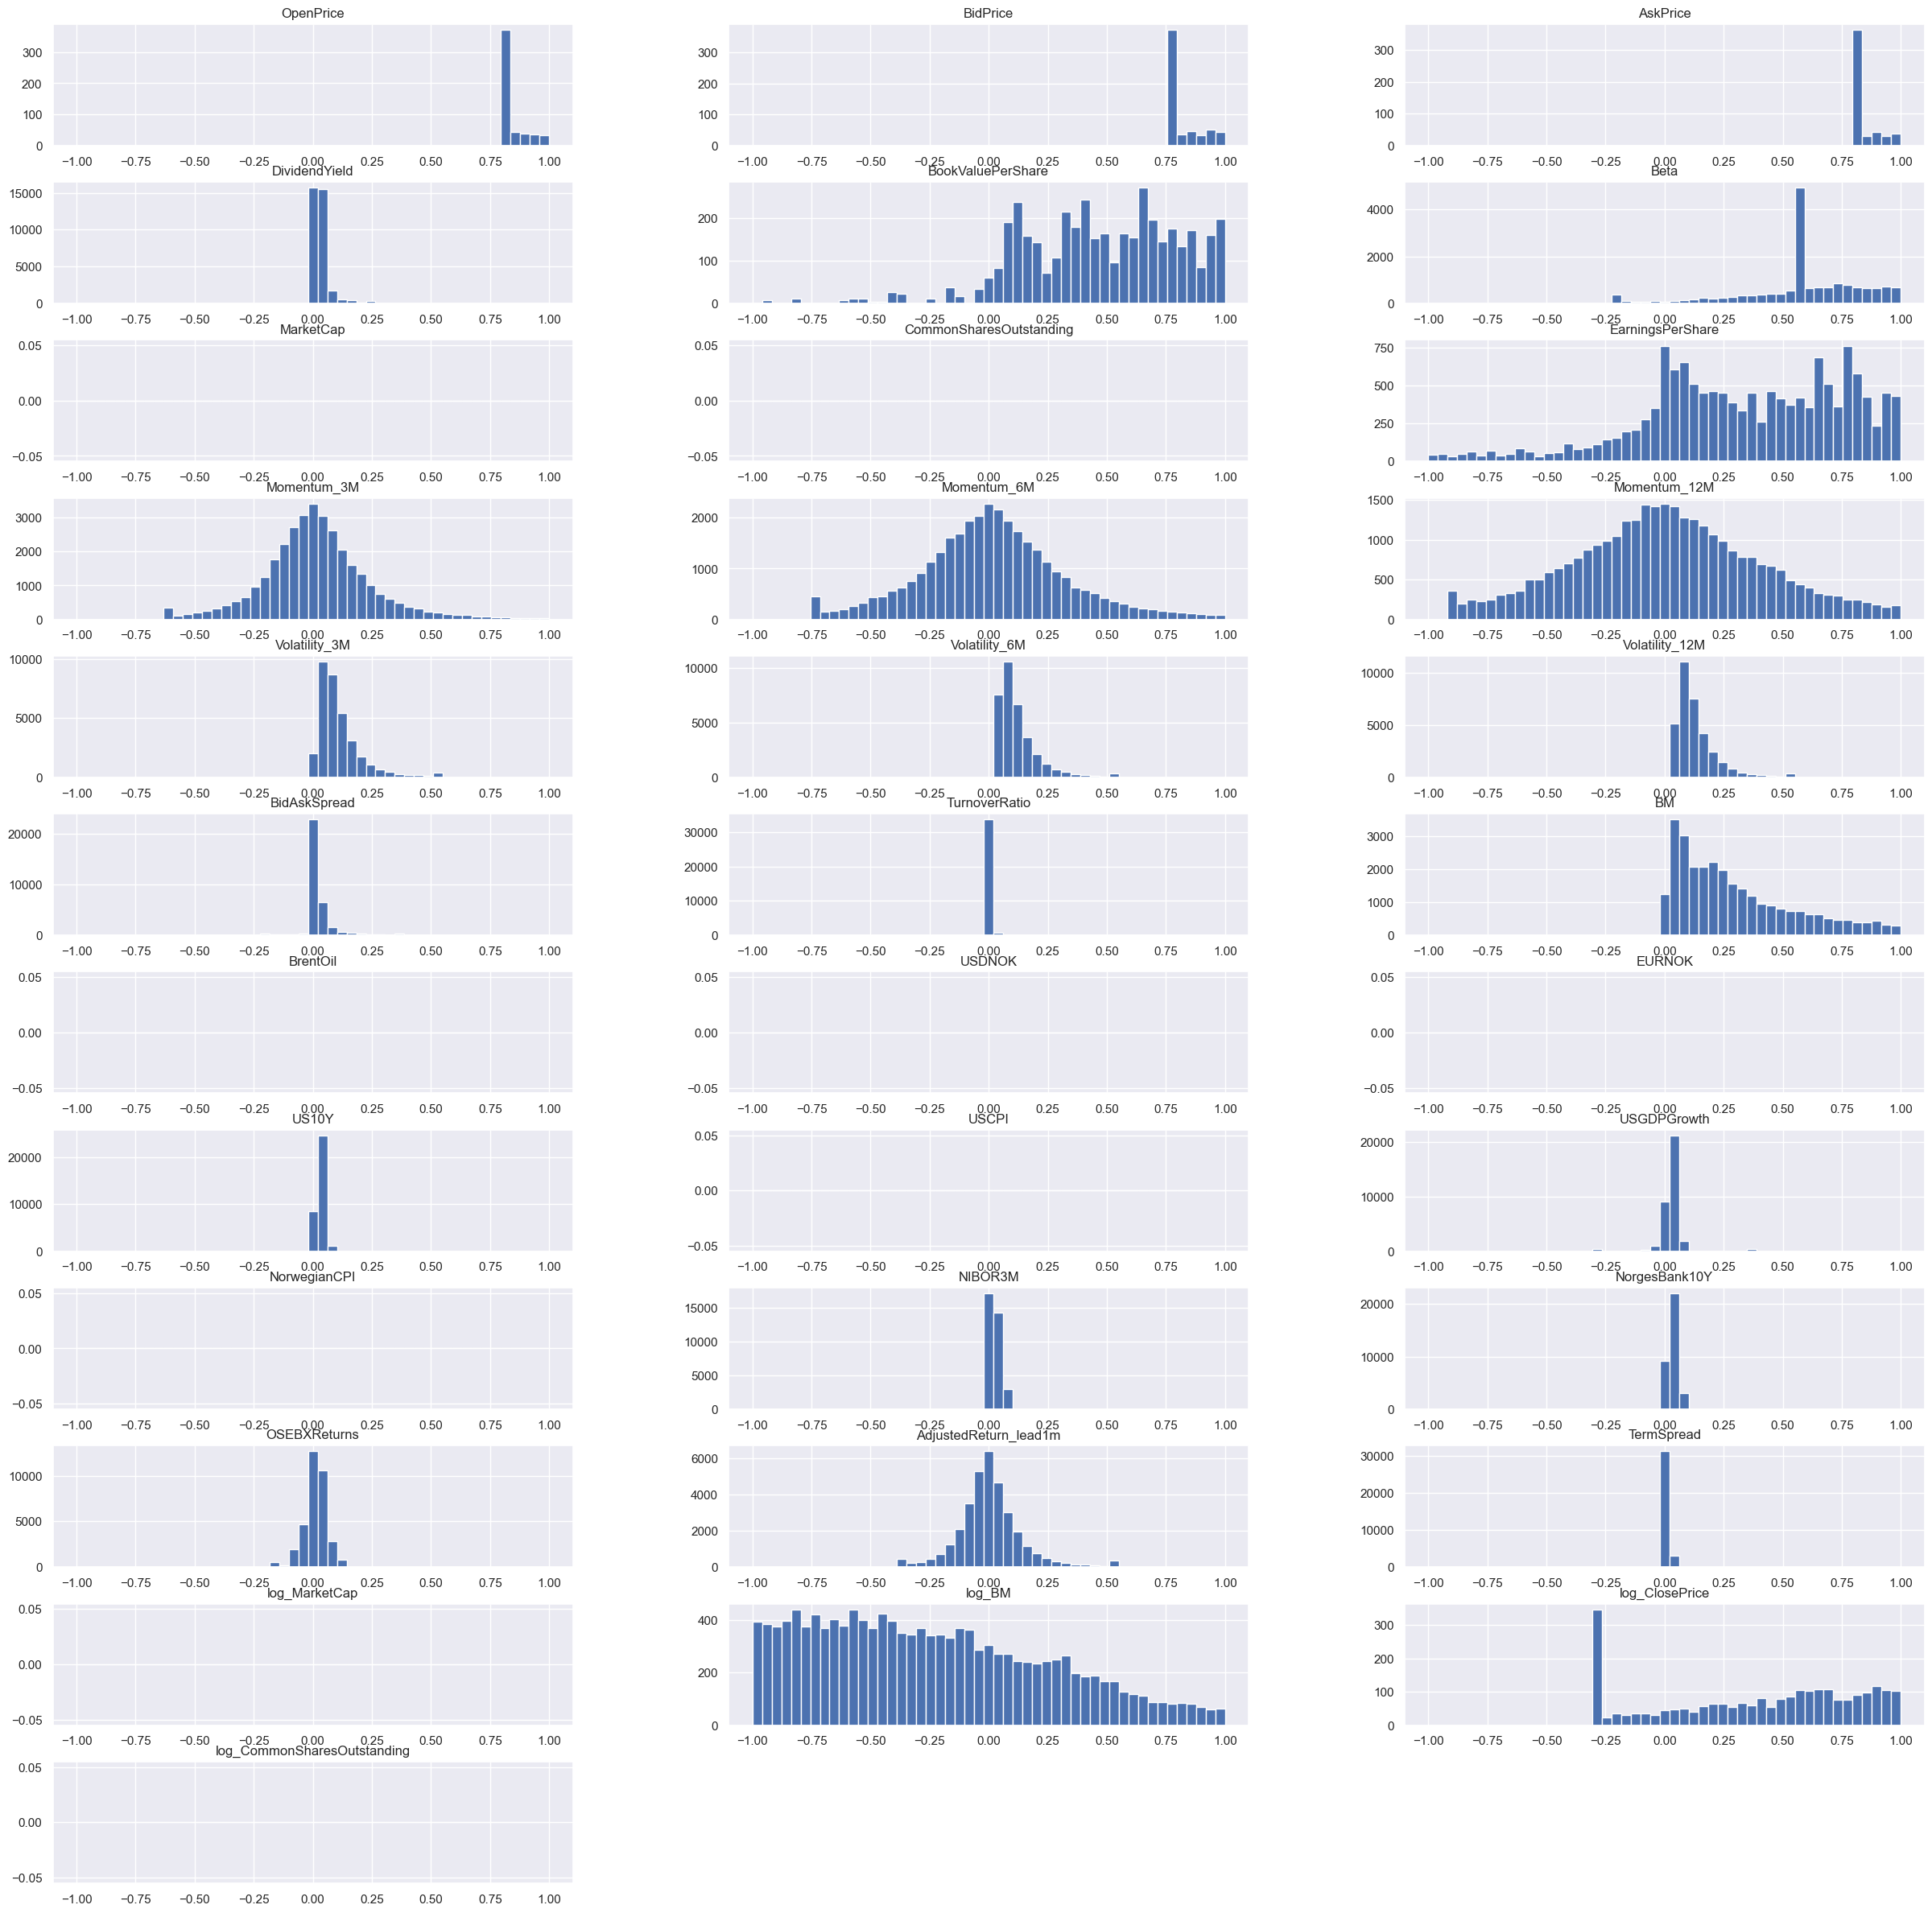

In [30]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
df[features].hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);

# Distribution of portfolio returns

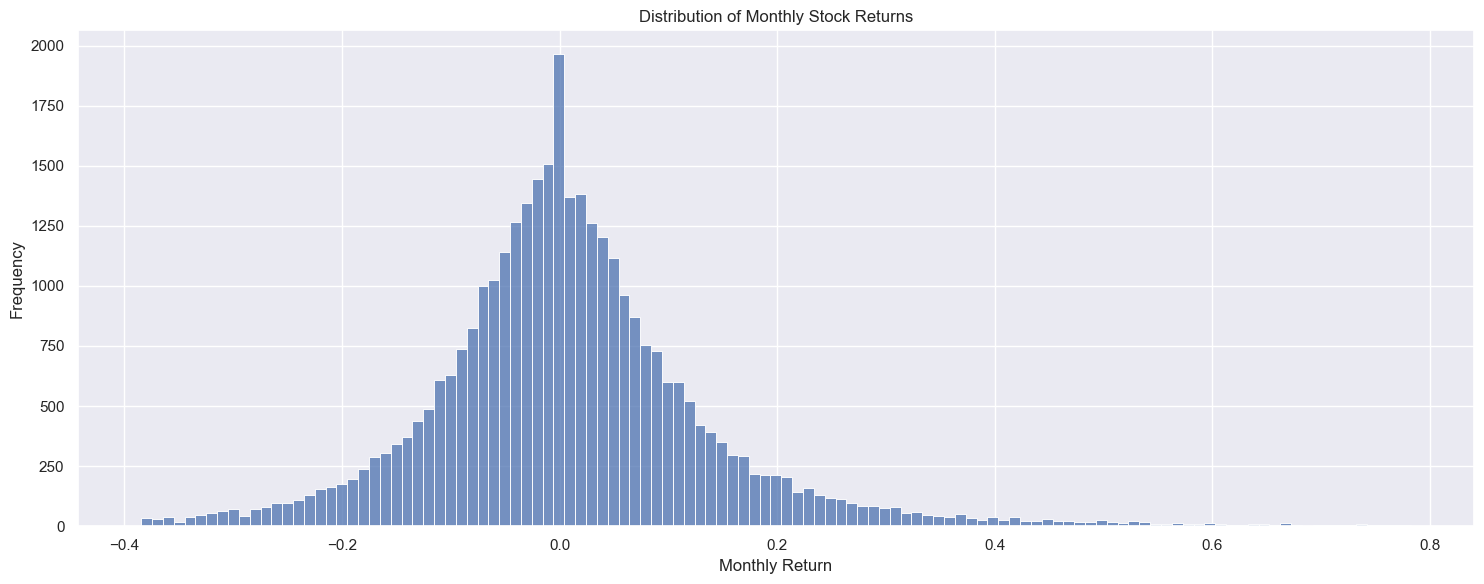

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Set figure size
rcParams['figure.figsize'] = 15, 6

# Prepare data
df_3 = df_2[["MonthlyReturn"]].copy()
df_3 = df_3.rename(columns={'MonthlyReturn': 'Stock return'})

# Plot histogram
sns.histplot(
    data=df_3,
    x="Stock return",
    binwidth=0.01,
    binrange=(df_3["Stock return"].min() + 1e-10, df_3["Stock return"].max() - 0.01)
)

# Customize and save
plt.title("Distribution of Monthly Stock Returns")
plt.xlabel("Monthly Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_returns_distribution.png')
plt.show()


# Distribution of firm size

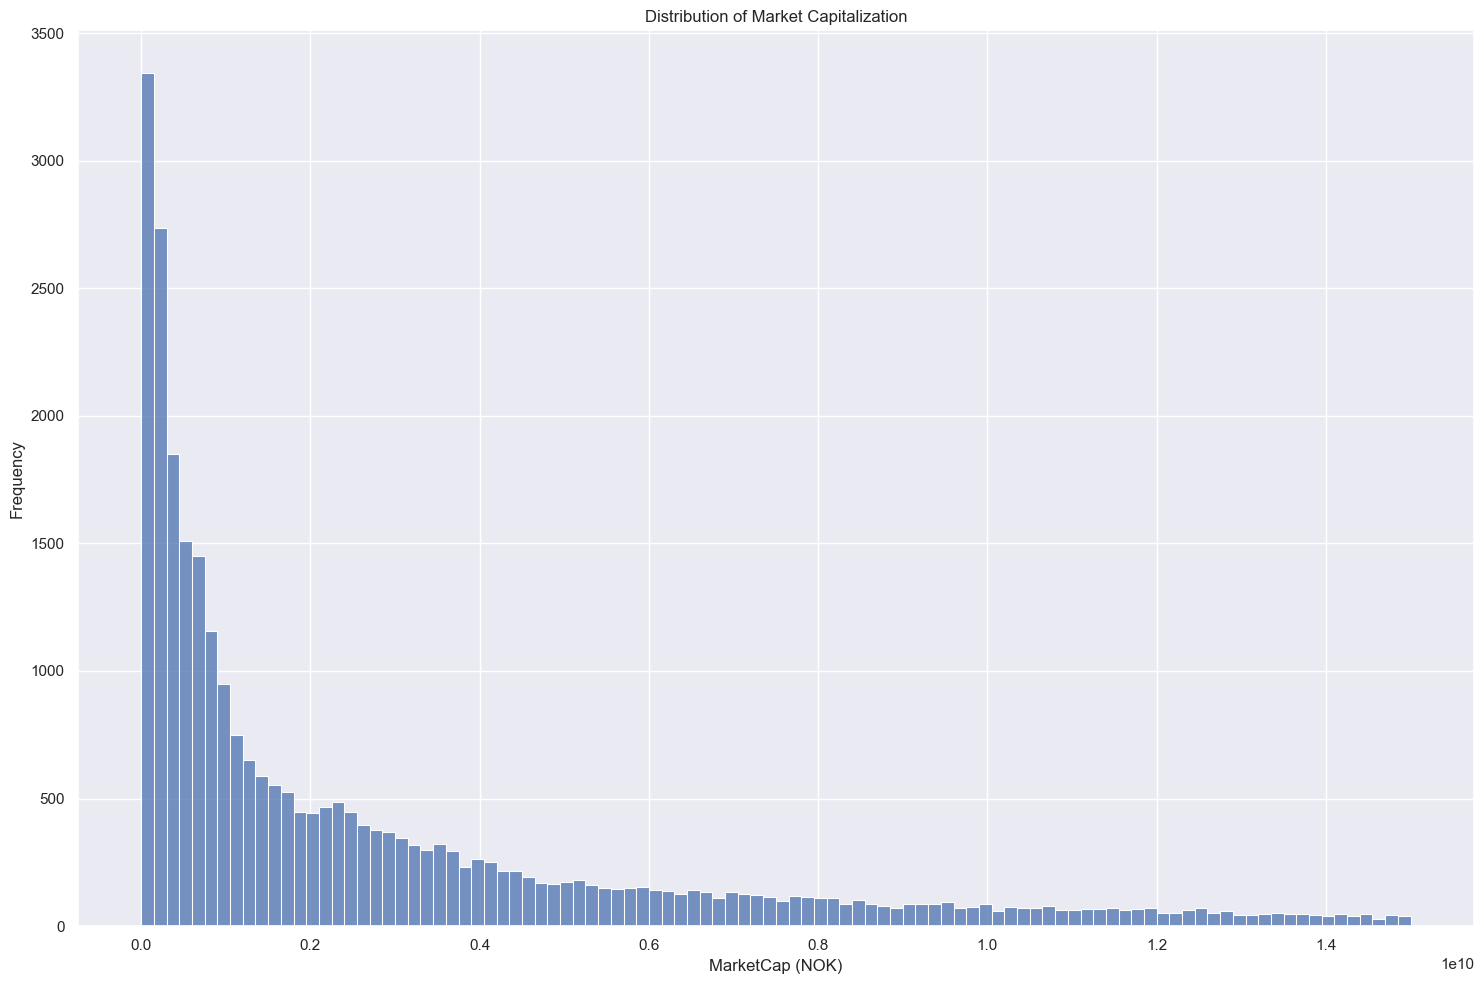

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# Set figure size
rcParams['figure.figsize'] = 15, 10

# Plot histogram of MarketCap
sns.histplot(data=df_2, x="MarketCap", binrange=(0, 1.5e10), bins=100)  # Adjust binrange for better zoom

# Customize and save
plt.title("Distribution of Market Capitalization")
plt.xlabel("MarketCap (NOK)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig('marketcap_distribution.png')
plt.show()


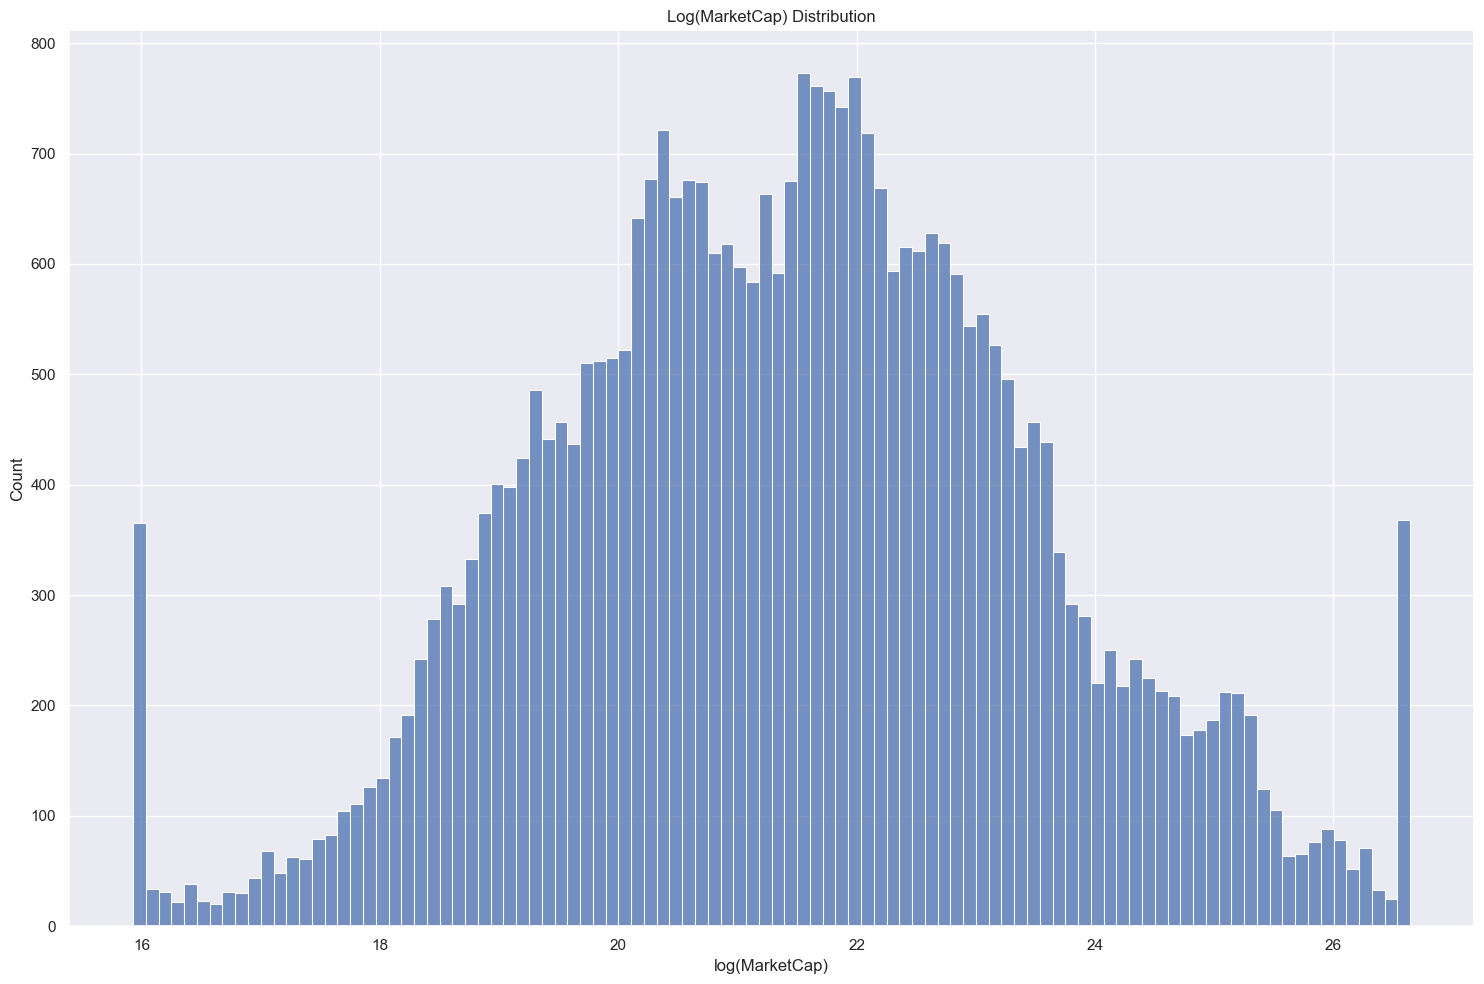

In [33]:
sns.histplot(data=df_2, x="log_MarketCap", bins=100)
plt.title("Log(MarketCap) Distribution")
plt.xlabel("log(MarketCap)")
plt.grid(True)
plt.tight_layout()
plt.savefig('log_marketcap_distribution.png')
plt.show()


# Equally weighted portfolio monthly returns over time

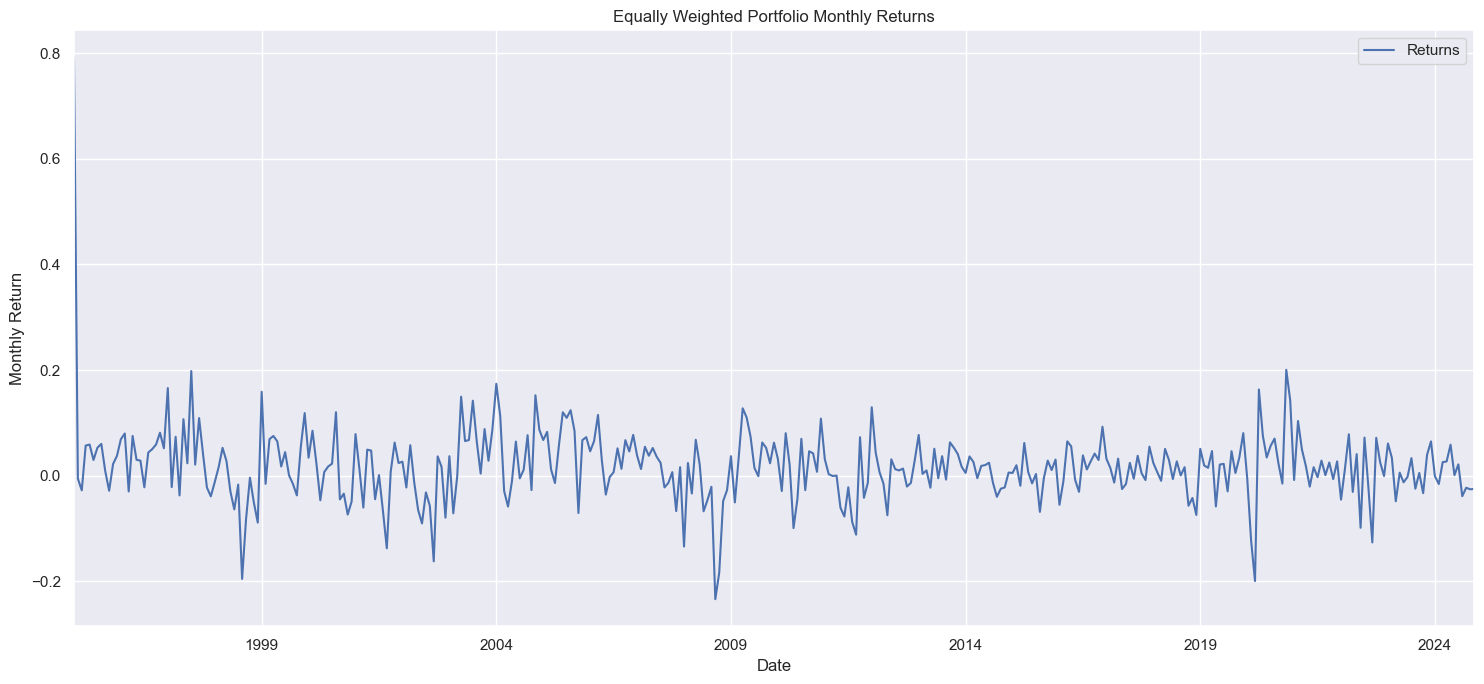

In [34]:
import matplotlib.pyplot as plt

# 1. Retain relevant columns
ret_data = df_2[["MonthlyReturn", "Instrument", "Date"]].copy()

# 2. Assign equal weights to each stock per month
ret_data["eq_weights"] = 1 / ret_data.groupby("Date")["Instrument"].transform("size")

# 3. Compute weighted return for each stock
ret_data["return_stock_ew"] = ret_data["MonthlyReturn"] * ret_data["eq_weights"]

# 4. Aggregate returns across all stocks per month
ret_data["Returns"] = ret_data.groupby("Date")["return_stock_ew"].transform("sum")

# 5. Drop duplicates to get one row per month
ret_data = ret_data[["Date", "Returns"]].drop_duplicates()

# 6. Set datetime index for plotting
ret_data.set_index("Date", inplace=True)

# 7. Plot the time series of equally weighted portfolio returns
ret_data.plot(grid=True, figsize=(15, 7), legend=True, title="Equally Weighted Portfolio Monthly Returns")

# 8. Save the figure
plt.ylabel("Monthly Return")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("portfolio_monthly_returns_over_time.png")
plt.show()


# Portfolio autocorrelation graph

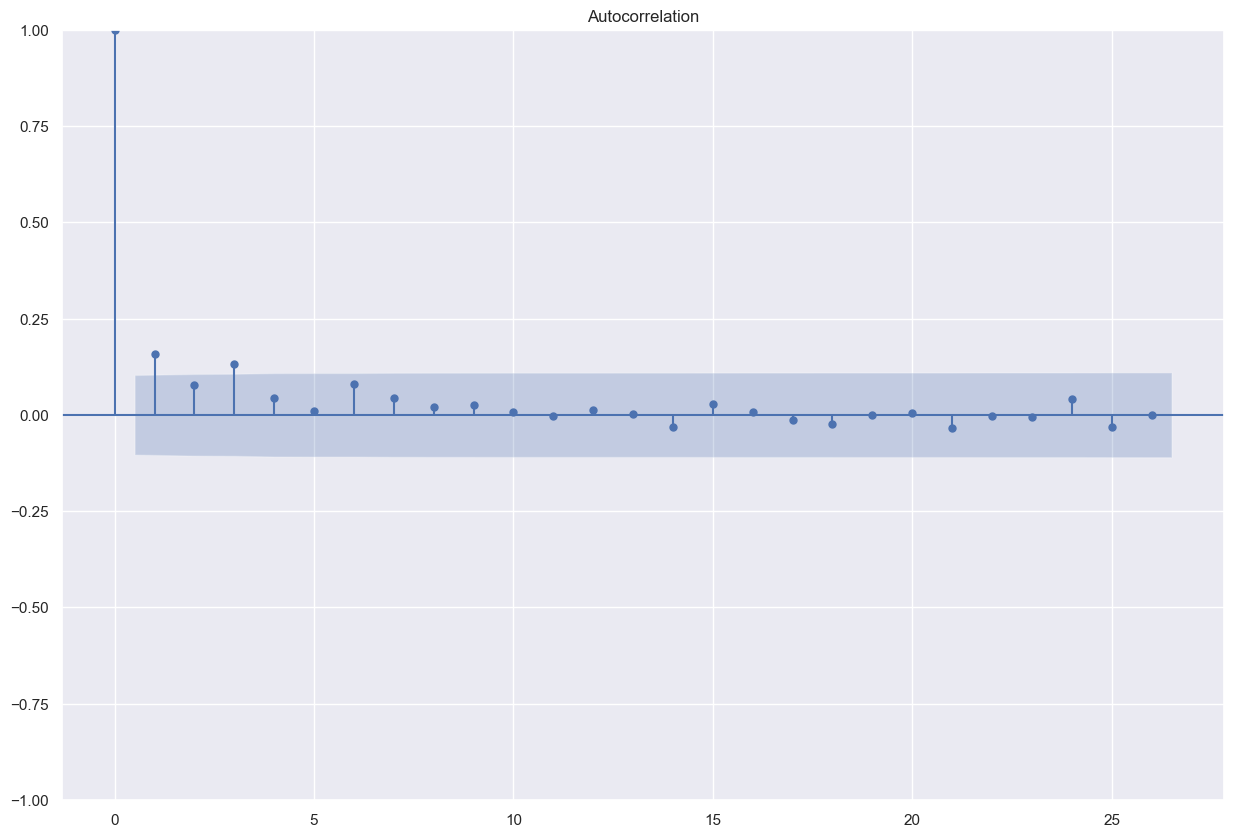

<Figure size 1500x1000 with 0 Axes>

In [35]:
plot_acf(ret_data)
# Show the data as a plot (via matplotlib)
plt.show()
plt.savefig('Portfolio autocorrelation graph.png')

# Variable Correlation Heatmap

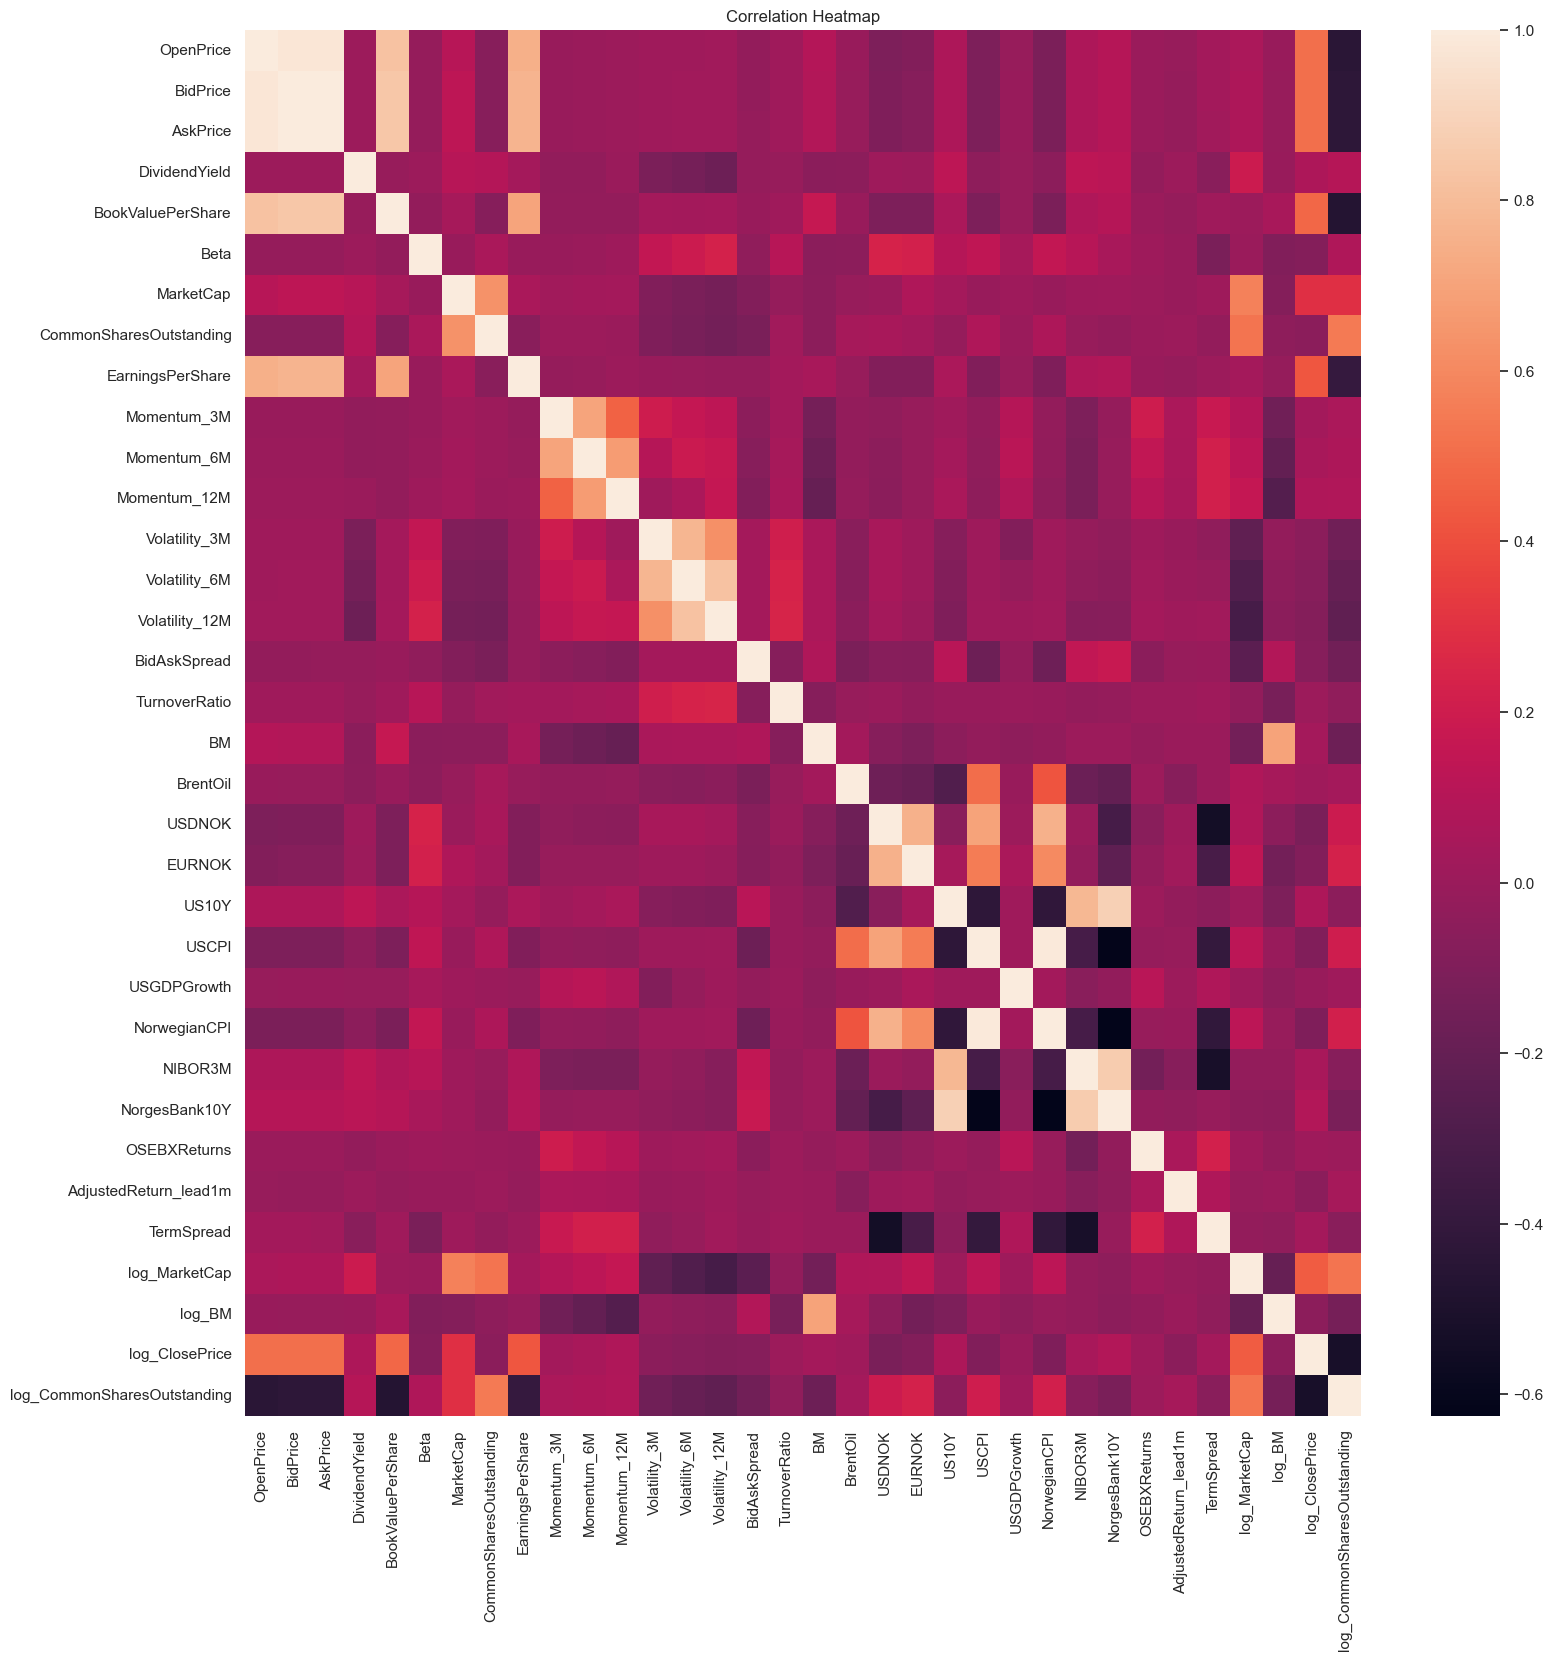

<Figure size 1500x1000 with 0 Axes>

In [36]:
features = df.columns[~df.columns.isin(['Instrument',"ClosePrice","Date","MonthlyReturn","AdjustedReturn", "EconomicSector"])].tolist()
plt.figure(figsize = (18,18))
sns.heatmap(data=df_2[features].corr())
plt.title('Correlation Heatmap')
plt.savefig('Correlation Heatmap.png')
plt.show()
plt.gcf().clear()

In [37]:
# Top Correlated Features (Pearson’s correlation)

In [38]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
c = df_2[features].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['Variable 1','Variable 2', 'corr']
so = so.sort_values(by = ['corr', 'Variable 1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,Variable 1,Variable 2,corr
0,BidPrice,AskPrice,0.999753
1,USCPI,NorwegianCPI,0.993412
2,OpenPrice,BidPrice,0.976268
3,OpenPrice,AskPrice,0.975647
4,US10Y,NorgesBank10Y,0.885411
5,NorgesBank10Y,NIBOR3M,0.861134
6,BookValuePerShare,AskPrice,0.843031
7,BookValuePerShare,BidPrice,0.841449
8,Volatility_6M,Volatility_12M,0.826117
9,OpenPrice,BookValuePerShare,0.825319


In [39]:
so.to_csv("variable_correlation.csv")

# Correlation of the stock level characteristics with the target variable (ret_exc_lead1m)

In [40]:
df_2.head()

,Date,Instrument,ClosePrice,OpenPrice,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,MarketCap,CommonSharesOutstanding,MonthlyReturn,EconomicSector,EarningsPerShare,Momentum_3M,Momentum_6M,Momentum_12M,Volatility_3M,Volatility_6M,Volatility_12M,BidAskSpread,TurnoverRatio,BM,BrentOil,USDNOK,EURNOK,US10Y,USCPI,USGDPGrowth,NorwegianCPI,NIBOR3M,NorgesBank10Y,OSEBXReturns,AdjustedReturn,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_CommonSharesOutstanding
0,1995-01-31,ABGA.OL,2.907500,2.945200,2.8697,2.907500,0.0363,3.5518,1.0787,4.846770e+08,166698880.0,0.792169,Energy,0.5294,-0.1502,-0.180600,0.0991,0.0916,0.1048,0.1180,0.013000,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,0.058002,0.0284,19.998993,-2.818423,1.067294,18.9317
1,1995-01-31,AFK.OL,11.897400,11.897400,14.7301,15.863200,0.0363,3.5518,1.0787,1.983283e+09,166698880.0,0.792169,Energy,0.5294,0.1365,0.113800,0.1881,0.0233,0.0421,0.0444,0.095200,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,0.016870,0.0284,21.408020,-2.818423,2.476320,18.9317
2,1995-01-31,ATEA.OL,47.069099,47.069099,94.1381,73.293198,0.0363,3.5518,1.0787,7.846366e+09,166698880.0,0.792169,Consumer Non-Cyclicals,0.5294,-0.4012,-0.753578,-0.8440,0.1920,0.2870,0.2097,-0.193413,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,-0.078362,0.0284,22.783316,-2.818423,3.851617,18.9317
3,1995-01-31,BELCO.OL,16.878401,17.245300,2.9354,5.136900,0.0363,3.5518,1.0787,2.813610e+09,166698880.0,0.792169,Basic Materials,0.5294,0.0382,0.164100,0.1736,0.0721,0.0635,0.0791,0.130400,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,0.058286,0.0284,21.757734,-2.818423,2.826035,18.9317
4,1995-01-31,BONHR.OL,26.500000,26.250000,46.2500,47.250000,0.0363,3.5518,1.0787,4.417520e+09,166698880.0,0.792169,Technology,0.5294,0.2871,0.181600,0.3242,0.0649,0.0948,0.0815,0.037700,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,-0.072971,0.0284,22.208845,-2.818423,3.277145,18.9317


In [41]:
import pandas as pd

# Step 1: Make sure you see everything
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Step 2: Select only numeric columns
df_numeric = df_2.select_dtypes(include='number')

# Step 3: Drop rows where the target is missing
df_clean = df_numeric.dropna(subset=["AdjustedReturn_lead1m"])

correlation = df_clean.corr()["AdjustedReturn_lead1m"].abs().sort_values(ascending=False)
corr_df = correlation.to_frame(name="Abs Correlation with Target")
display(corr_df)

,Abs Correlation with Target
AdjustedReturn_lead1m,1.000000
TermSpread,0.074617
NIBOR3M,0.073143
BrentOil,0.072058
Momentum_3M,0.062650
OSEBXReturns,0.058265
log_ClosePrice,0.056670
Momentum_6M,0.056397
Momentum_12M,0.052922
log_CommonSharesOutstanding,0.044385


In [42]:
corr_df.to_csv("target_correlation.csv")

In [43]:
# Final data 

In [44]:
import pandas as pd
import numpy as np

# Read the CSV, parse dates
df = pd.read_csv("Cleaned_OSEFX_Market_Macro_Data_new.csv", parse_dates=["Date"])

# Sort by date and instrument (your actual columns)
df = df.sort_values(by=["Date", "Instrument"]).reset_index(drop=True)

# Convert numeric columns only to float32
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].astype("float32")

# Optional: Check the result
print(df.dtypes)
df.head()


Date                           datetime64[ns]
Instrument                             object
ClosePrice                            float32
OpenPrice                             float32
BidPrice                              float32
AskPrice                              float32
DividendYield                         float32
BookValuePerShare                     float32
Beta                                  float32
MarketCap                             float32
CommonSharesOutstanding               float32
MonthlyReturn                         float32
EconomicSector                         object
EarningsPerShare                      float32
Momentum_3M                           float32
Momentum_6M                           float32
Momentum_12M                          float32
Volatility_3M                         float32
Volatility_6M                         float32
Volatility_12M                        float32
BidAskSpread                          float32
TurnoverRatio                     

,Date,Instrument,ClosePrice,OpenPrice,BidPrice,AskPrice,DividendYield,BookValuePerShare,Beta,MarketCap,CommonSharesOutstanding,MonthlyReturn,EconomicSector,EarningsPerShare,Momentum_3M,Momentum_6M,Momentum_12M,Volatility_3M,Volatility_6M,Volatility_12M,BidAskSpread,TurnoverRatio,BM,BrentOil,USDNOK,EURNOK,US10Y,USCPI,USGDPGrowth,NorwegianCPI,NIBOR3M,NorgesBank10Y,OSEBXReturns,AdjustedReturn,AdjustedReturn_lead1m,TermSpread,log_MarketCap,log_BM,log_ClosePrice,log_CommonSharesOutstanding
0,1995-01-31,ABGA.OL,2.907500,2.945200,2.8697,2.907500,0.0363,3.5518,1.0787,4.846770e+08,166698880.0,0.792169,Energy,0.5294,-0.1502,-0.180600,0.0991,0.0916,0.1048,0.1180,0.013000,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,0.058002,0.0284,19.998993,-2.818423,1.067294,18.9317
1,1995-01-31,AFK.OL,11.897400,11.897400,14.7301,15.863200,0.0363,3.5518,1.0787,1.983283e+09,166698880.0,0.792169,Energy,0.5294,0.1365,0.113800,0.1881,0.0233,0.0421,0.0444,0.095200,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,0.016870,0.0284,21.408020,-2.818423,2.476320,18.9317
2,1995-01-31,ATEA.OL,47.069099,47.069099,94.1381,73.293198,0.0363,3.5518,1.0787,7.846366e+09,166698880.0,0.792169,Consumer Non-Cyclicals,0.5294,-0.4012,-0.753578,-0.8440,0.1920,0.2870,0.2097,-0.193413,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,-0.078362,0.0284,22.783316,-2.818423,3.851617,18.9317
3,1995-01-31,BELCO.OL,16.878401,17.245300,2.9354,5.136900,0.0363,3.5518,1.0787,2.813610e+09,166698880.0,0.792169,Basic Materials,0.5294,0.0382,0.164100,0.1736,0.0721,0.0635,0.0791,0.130400,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,0.058286,0.0284,21.757734,-2.818423,2.826035,18.9317
4,1995-01-31,BONHR.OL,26.500000,26.250000,46.2500,47.250000,0.0363,3.5518,1.0787,4.417520e+09,166698880.0,0.792169,Technology,0.5294,0.2871,0.181600,0.3242,0.0649,0.0948,0.0815,0.037700,0.001,0.0597,16.799999,6.68,11.7673,0.0668,154.699997,0.014,67.699997,0.0566,0.0736,-0.0201,0.785085,-0.072971,0.0284,22.208845,-2.818423,3.277145,18.9317


In [45]:
features_to_keep = [
    # Firm-specific
    'DividendYield', 'BookValuePerShare', 'Beta', 'EarningsPerShare',
    'Momentum_3M', 'Momentum_6M', 'Momentum_12M',
    'Volatility_3M', 'Volatility_6M', 'Volatility_12M',
    'BidAskSpread', 'TurnoverRatio', 'BM',
    'log_MarketCap', 'log_BM', 'log_ClosePrice', 'log_CommonSharesOutstanding',
    
    # Macro
    'BrentOil', 'USDNOK', 'EURNOK', 'US10Y', 'USCPI', 'USGDPGrowth',
    'NorwegianCPI', 'NIBOR3M', 'NorgesBank10Y', 'TermSpread', 'OSEBXReturns'
]

target_variable = 'AdjustedReturn_lead1m'
